__Project:__ Intent Recognition <br> 
__Sub-prj:__ HuggingFace Pre-trained <br>
__Experm:__ Classification with distilbert-base-uncased <br>
__Devl by:__ Amir Hossini <br>
__Dev Dat:__ Oct 6, 2021 <br>

#### Libraries

In [31]:
import numpy as np
import pandas as pd
import csv
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

print(f"Tensorflow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.5.0
Transformers version: 4.11.3
Num GPUs Available:  1


#### I/O Files & Params

In [19]:
fl_train = '../datasets/banking77/train.csv'
fl_test  = '../datasets/banking77/test.csv'

#### Import files, Basics

In [20]:
train = pd.read_csv(fl_train)
test  = pd.read_csv(fl_test)

print('\nTraining Dataset:')
display(train)
print('Traning Classes:')
display(len(train.category.unique()))
print('\nTesting Dataset:')
display(test)
print('Testing Classes:')
display(len(test.category.unique()))

training_sentences = list(train.loc[:,'text'])
validation_sentences = list(test.loc[:,'text'])
training_labels, levels = pd.factorize(train.loc[:,'category'])
label_keys=dict(zip(levels,range(len(levels))))
validation_labels = test.loc[:,'category'].map(lambda x: label_keys[x])


Training Dataset:


,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival
...,...,...
9998,You provide support in what countries?,country_support
9999,What countries are you supporting?,country_support
10000,What countries are getting support?,country_support
10001,Are cards available in the EU?,country_support


Traning Classes:


77


Testing Dataset:


,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival
...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support
3076,How many countries do you support?,country_support
3077,What countries do you do business in?,country_support
3078,What are the countries you operate in.,country_support


Testing Classes:


77

In [21]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [22]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True,
                            return_tensors='tf')
val_encodings = tokenizer(validation_sentences,
                          truncation=True,
                          padding=True,
                          return_tensors='tf')

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [27]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=77)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [29]:
history = model.fit(train_dataset.shuffle(100).batch(64),
          epochs=10,
          batch_size=64,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/10
157/157 [==============================] - 80s 481ms/step - loss: 4.3007 - accuracy: 0.0275 - val_loss: 4.3654 - val_accuracy: 0.0130
Epoch 2/10
157/157 [==============================] - 76s 483ms/step - loss: 3.6037 - accuracy: 0.0841 - val_loss: 4.5451 - val_accuracy: 0.0130
Epoch 3/10
157/157 [==============================] - 76s 487ms/step - loss: 2.8761 - accuracy: 0.1521 - val_loss: 5.0941 - val_accuracy: 0.0130
Epoch 4/10
157/157 [==============================] - 76s 487ms/step - loss: 2.4559 - accuracy: 0.1745 - val_loss: 5.6166 - val_accuracy: 0.0130
Epoch 5/10
157/157 [==============================] - 76s 486ms/step - loss: 2.1842 - accuracy: 0.2140 - val_loss: 6.5902 - val_accuracy: 0.0130
Epoch 6/10
157/157 [==============================] - 77s 493ms/step - loss: 2.0136 - accuracy: 0.2421 - val_loss: 7.0127 - val_accuracy: 0.0136
Epoch 7/10
157/157 [==============================] - 76s 483ms/step - loss: 2.2020 - accuracy: 0.2037 - val_loss: 7.6192 - val_ac

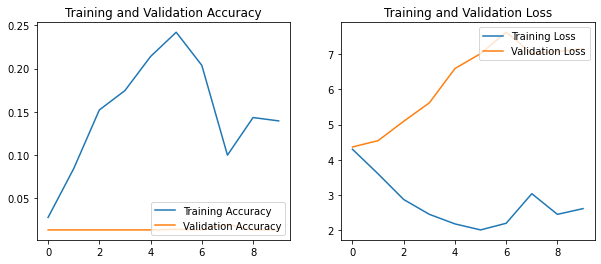

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()